<a href="https://colab.research.google.com/github/DonnaVakalis/Urban.dat/blob/master/SolarCap_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyze Toronto's Rooftop Solar Capacity

 

## Table of Contents
- [Introduction](#intro)
- [Part I - Setup ](#partone)
- [Part II - Calculations from scratch ](#parttwo)
- [Part III - Comparison with Google EIE](#partthree)


<a id='intro'></a>
### Introduction
 


<a id='partone'></a>
### Part I - Setup

In [1]:
# import libraries

!pip install statsmodels

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from google.colab import drive
import statsmodels as sm

%matplotlib inline
 

In [2]:
# Mount Google Drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/")

Mounted at /content/gdrive


In [3]:
# Load csv files
base_dir =  "/content/gdrive/My Drive/Colab Notebooks/SSG/SolarPV_capacity/"

# all non-residential buildings
file = base_dir + "df_nonRes_footprint.csv"
df1 = pd.read_csv(file)

# load all residential buildings
file = base_dir + "df_all_footprint.csv"
df2= pd.read_csv(file) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID_TAZ           4320 non-null   int64  
 1   buildingEmpType  4320 non-null   object 
 2   footprint_sf     4320 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 101.4+ KB


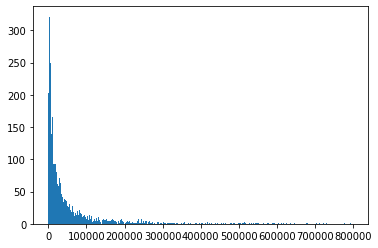

In [19]:
# Look at dfs, document what needs cleaning & tidying (non-residential)
# Do any of the rows have missing values?
df1.info()

# Look at footprints distribution 
data= df1['footprint_sf']
nbins= 500
xmin = 0
xmax = 800000
plt.hist(data, bins=nbins,range=[xmin,xmax]);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16934 entries, 0 to 16933
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID_TAZ          16934 non-null  int64  
 1   buildingClass   16934 non-null  object 
 2   yearbuiltClass  16934 non-null  int64  
 3   bsmtArea_sf     16934 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 529.3+ KB
Mean estimated roof area of residence is  97735.65820047107 .


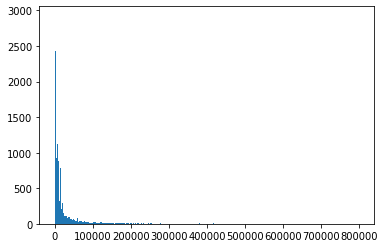

In [27]:
# Look at dfs, document what needs cleaning & tidying (residential)
df2.info()

# Look at footprints distribution 
data= df2['bsmtArea_sf']
nbins= 500
xmin = 0
xmax = 800000
plt.hist(data, bins=nbins,range=[xmin,xmax]);

# Mean estimated roof area (using bsmtArea_sf)
mu_res = df1['footprint_sf'].mean()
print('Mean estimated roof area of residence is ',mu_res,'.')

Cleaning Notes:
- Pretty clean (not surprising given it was output from model)
- Based on the magnitude of the floor areas 'bsmtArea_sf' column , these are not individual buildings and for now don't know the underlying count of buildings that have been aggregated into the number in ... e.g., so can't subtract the perimeter or check for minimum indivisual size as per EIE method


<a id='parttwo></a>
### Part II - SSG Calculations

Assumptions:
- Residential 8% of rooftops are flat/ 92% pitched
- Commerical 63% of rooftops are flat / 37% pitched
- For pitched: still use basement/footprint as raw 'area' of roof surface 
- Don't have numbers of buildings, so no median

Space & obstacles:
- Flat roofs 65% are unshaded 
- Pitched roofs are 58.5% unshaded 

Installation size: 
- no constraints

Sunlight: 
- 110 W/m2 for flat  
- 135 W/m2 for pitched 

Annual Potential:
-  1153 kwH / kW PV installed (data point for south-facing, tilt= latitutde -15deg but applied to all)

Other:
- Use an efficiency performance factor of 75% to account for losses (e.g., climatic factors, inverter, conversion losses...)


In [37]:
# Set Assumptions as named variables
RES_PRCT_FLAT = 0.08
RES_PRCT_PITCH = 1-RES_PRCT_FLAT 

COMM_PRCT_FLAT = 0.63
COMM_PRCT_PITCH = 1 - COMM_PRCT_FLAT

FLAT_PRCT_UNSHADED = 0.65
PITCH_PRCT_UNSHADED = 0.585

FLAT_CAP = 110
PITCH_CAP =135

EFF_FACTOR = 0.75

PART IIA - SSG RESIDENTIAL

In [46]:
# Total Residential Roof Space (in square meters)
res_total = df1['footprint_sf'].sum()/10.763910417  #convert square feet to square meters
res_flat = res_total*RES_PRCT_FLAT  # see assumptions about percent of residential that are flat versus pitched
res_pitched = res_total*RES_PRCT_PITCH

# Total Residential Roof Unshaded
res_unshaded =  res_flat*FLAT_PRCT_UNSHADED + res_pitched*PITCH_PRCT_UNSHADED #see assumptions about unshaded area for flat versus pitched

# Total Residential Capacity (in Watts)
res_capacity = res_flat*FLAT_PRCT_UNSHADED*FLAT_CAP + res_pitched*PITCH_PRCT_UNSHADED*PITCH_CAP  # 110 Watts/m2 eligible flat and 135 W/m2 pitched

# Total Residential Annual Generation (in kWh)
res_gen = res_capacity*EFF_FACTOR*1153 #1153 kWh per KW installed PV)

print('Total Residential Annual Generation Potential is',round(res_gen/(10e3)),'MegaWatt-hours') 

Total Residential Annual Generation Potential is 265855666.0 MegaWatt-hours


PART IIB - SSG NON-RES or COMMERCIAL

In [47]:
# Total Commercial Roof Space (in square meters)
comm_total = df2['bsmtArea_sf'].sum()/10.763910417  #convert square feet to square meters
comm_flat = comm_total*COMM_PRCT_FLAT  # see assumptions about percent of residential that are flat versus pitched
comm_pitched = comm_total*COMM_PRCT_PITCH

# Total Residential Roof Unshaded
comm_unshaded =  comm_flat*FLAT_PRCT_UNSHADED + comm_pitched*PITCH_PRCT_UNSHADED #see assumptions about unshaded area for flat versus pitched

# Total Residential Capacity (in Watts)
comm_capacity = comm_flat*FLAT_PRCT_UNSHADED*FLAT_CAP + comm_pitched*PITCH_PRCT_UNSHADED*PITCH_CAP  # 110 Watts/m2 eligible flat and 135 W/m2 pitched

# Total Residential Annual Generation (in kWh)
comm_gen = comm_capacity*EFF_FACTOR*1153 #1153 kWh per KW installed PV)

print('Total Commerical Annual Generation Potential is',round(comm_gen/(10e3)),'MegaWatt-hours') 

Total Commerical Annual Generation Potential is 317733755.0 MegaWatt-hours


TOTAL

In [48]:
total_gen = res_gen + comm_gen
print('Total Annual Generation Potential is',round(total_gen/(10e3)),'MegaWatt-hours')

Total Annual Generation Potential is 583589421.0 MegaWatt-hours


<a id='partthree'></a>
### Part III - Google EIE Comparison

1) What are the results from Google EIE for Toronto?

2) What would be the results from the SSG-Julia method using Google's estimate of building footprint totals 

3) What are the deltas between #1 and #2 and the SSG method from Part II? 

EIE Assumptions:

Sunlight: Every included panel receives at least 75 percent of the maximum annual sun in the county. In cases where a building is not in a county, the maximum sun is determined by the max sun received in the city.

Installation size: Each panel is assumed to be 250 Watts with an efficiency of 15.3 percent, a DC to AC derate factor of 85 percent and industry-standard assumptions about other factors. Every included roof has a total potential installation size of at least 2kW and fewer than 1,000kW.

Space & obstacles: Only areas of the roof with enough space to install four adjacent solar panels are included. Obstacles like chimneys are taken into account. Panels are assumed to be mounted flush with the roof, including on flat surfaces. Only solar arrays on buildings are considered, not other spaces such as parking lots or fields.

Part III A: What are the results from Google EIE for Toronto?

In [ ]:
#From Google EIE for Toronto
total_gen_EIE = 8200000 #MWH per year

Part III B: What are the results from Google EIE for Toronto, if we use SSG building footprints and/or swap some other assumptions?




In [56]:
# Compare assumptions about 'useable' roof area
EIE_useable = 48100000
print('EIE Total Roofspace is', round(EIE_useable),'m2')
print ('SSG Total Roofsapce is', round(res_unshaded + comm_unshaded), 'm2') 

# If SSG used EIE's total useable roofspace...then what would the SSG solar capacity number be?
# We don't know the res/comm split of roof area for the EIE numbers (it is not given or derivable from what is given), but keeping it consistent with SSG split
PRCT_RES = res_total/(res_total + comm_total) 



EIE Total Roofspace is 48100000 m2
SSG Total Roofsapce is 54119558.0 m2


What conversion factors would align our estimates? I.e., make 1153 into a variable and holding all other things constant what would the average be?
Or what about a slightly lower total roofspace (check assumptions from Paidipati)